In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns

from sklearn import preprocessing

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from nltk.corpus import stopwords
import string

import spacy

from wordcloud import WordCloud
from collections import Counter

import os

In [2]:
uber = pd.read_csv('/content/uber_reviews_without_reviewid.csv')

In [5]:
uber.shape

(12000, 10)

In [6]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   userName              12000 non-null  object 
 1   userImage             0 non-null      float64
 2   content               12000 non-null  object 
 3   score                 12000 non-null  int64  
 4   thumbsUpCount         12000 non-null  int64  
 5   reviewCreatedVersion  10260 non-null  object 
 6   at                    12000 non-null  object 
 7   replyContent          33 non-null     object 
 8   repliedAt             33 non-null     object 
 9   appVersion            10260 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 937.6+ KB


In [7]:
uber['at'] = pd.to_datetime(uber['at'])

In [8]:
uber['at_month'] = uber['at'].dt.month
uber['at_day'] = uber['at'].dt.day
uber['at_hour'] = uber['at'].dt.hour

del uber['at']

In [9]:
reply_content = np.where(uber['replyContent'].isna(), 0, 1)
uber['replyContent'] = reply_content

In [10]:
uber.describe().T

count       mean       std   min   25%   50%   75%    max
userImage          0.0        NaN       NaN   NaN   NaN   NaN   NaN    NaN
score          12000.0   3.925417  1.658940   1.0   3.0   5.0   5.0    5.0
thumbsUpCount  12000.0   0.517000  6.298268   0.0   0.0   0.0   0.0  239.0
replyContent   12000.0   0.002750  0.052370   0.0   0.0   0.0   0.0    1.0
at_month       12000.0  11.731833  0.443023  11.0  11.0  12.0  12.0   12.0
at_day         12000.0  13.919750  9.374307   1.0   6.0  12.0  25.0   30.0
at_hour        12000.0  12.785583  6.758643   0.0   8.0  13.0  19.0   23.0

In [11]:
uber.select_dtypes(include='object').describe().T

count unique                  top  freq
userName              12000  12000               User_0     1
content               12000   8172                 Good   985
reviewCreatedVersion  10260    142          4.554.10001  3187
repliedAt                33     33  2019-07-14 11:38:48     1
appVersion            10260    142          4.554.10001  3187

In [12]:
uber.isnull().sum()

userName                    0
userImage               12000
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion     1740
replyContent                0
repliedAt               11967
appVersion               1740
at_month                    0
at_day                      0
at_hour                     0
dtype: int64

In [13]:
uber['userName'].duplicated().sum()

0

In [14]:
uber.index = uber['userName']

del uber['userName']
del uber['userImage']

In [15]:
uber['content'] = uber['content'].str.lower()

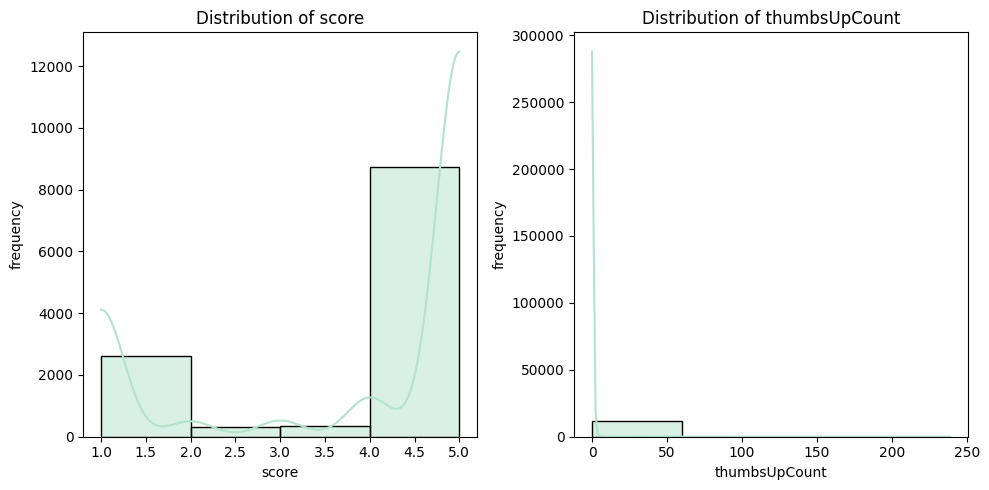

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Use 'Pastel2' which is a valid Seaborn palette name
palette = sns.color_palette('Pastel2')
for i, column in enumerate(uber[['score', 'thumbsUpCount']]):
  sns.histplot(data=uber[column], ax=axes[i], bins=4, kde=True, color=palette[0])
  axes[i].set_title(f'Distribution of {column}')
  axes[i].set_ylabel('frequency')

plt.tight_layout()
plt.show()

<Axes: >

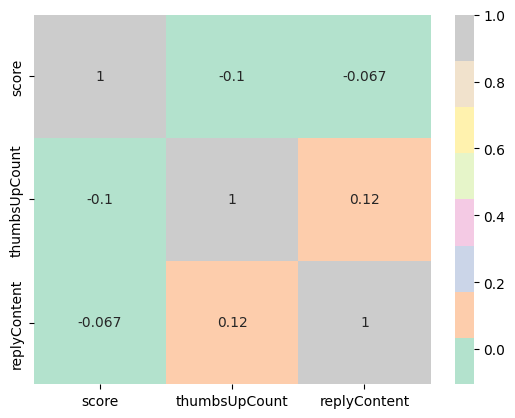

In [20]:
sns.heatmap(data=uber[['score', 'thumbsUpCount', 'replyContent']].corr(),
            cmap='Pastel2',
            annot=True)

<Axes: title={'center': 'Distribution by Months'}, xlabel='months', ylabel='frequency'>

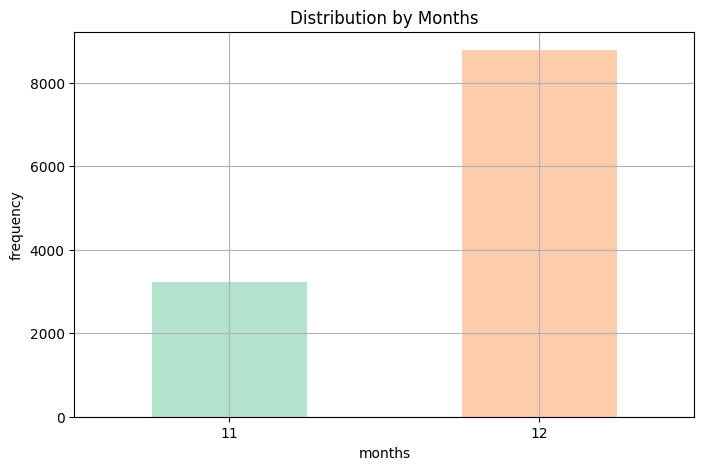

In [22]:
month = uber['at_month'].value_counts().sort_index(ascending=True)

month.plot(kind='bar', grid=True, figsize=(8,5), xlabel='months', ylabel='frequency',
           legend=False, title='Distribution by Months', rot=0,
           color=sns.color_palette('Pastel2'))

<Axes: title={'center': 'Distribution by Days'}, xlabel='day', ylabel='frequency'>

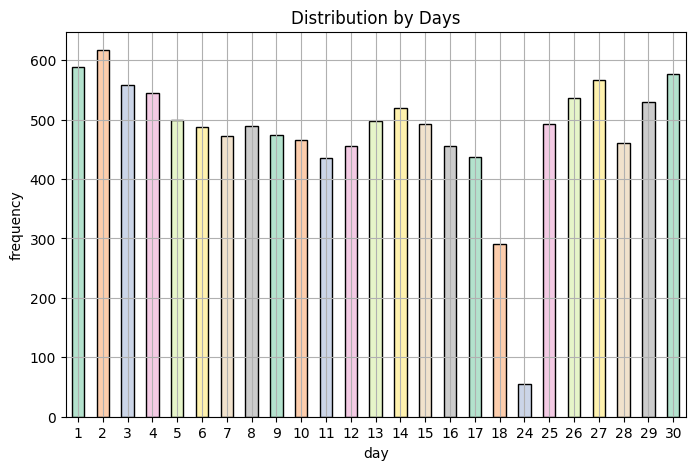

In [23]:
day = uber['at_day'].value_counts().sort_index(ascending=True)

day.plot(kind='bar', grid=True, figsize=(8, 5), xlabel='day', ylabel='frequency',
         legend=False, title='Distribution by Days',
         edgecolor='black', rot=0,
         color=sns.color_palette('Pastel2'))

<Axes: title={'center': 'Distribution by Hour'}, xlabel='hours', ylabel='frequency'>

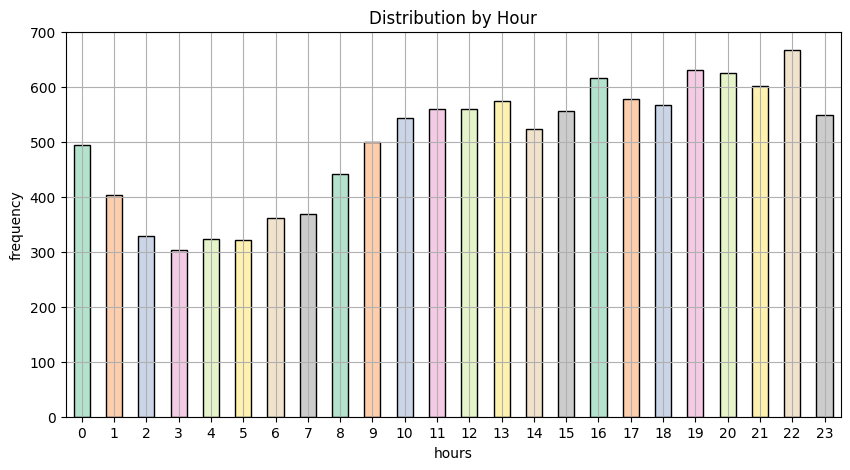

In [25]:
hour = uber['at_hour'].value_counts().sort_index(ascending=True)

hour.plot(kind='bar', grid=True, figsize=(10,5), xlabel='hours', ylabel='frequency',
           legend=False, title='Distribution by Hour', edgecolor='black',rot=0,
           color=sns.color_palette('Pastel2'))

<Axes: title={'center': 'Trends in Average Daily Score per Month'}, xlabel='month, day', ylabel='avg. score'>

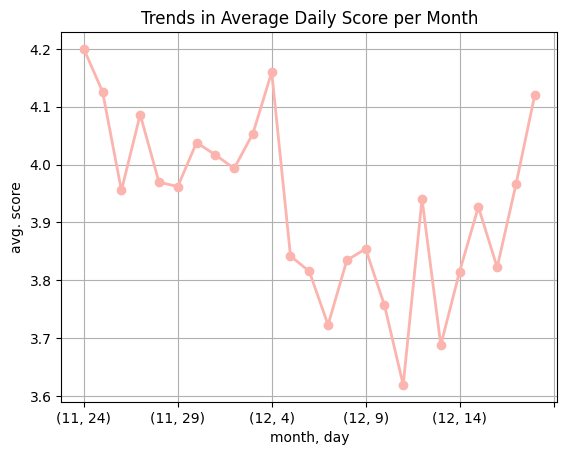

In [27]:
date_score = uber.groupby(['at_month','at_day'])['score'].mean()
date_score.plot(kind='line', grid=True, xlabel='month, day', ylabel='avg. score',
               color=sns.color_palette('Pastel1'), linewidth=2, marker='o',
                title='Trends in Average Daily Score per Month')

In [33]:
import nltk
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()


'''
def valer_analyze(review):
    score = analyzer.polarity_scores(review)['compound']
    return score

    if score >= 0.05:
        return 'postive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'
'''

uber['vader_neg'] = uber['content'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
uber['vader_neu'] = uber['content'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
analyzer = SentimentIntensityAnalyzer()


'''
def valer_analyze(review):
    score = analyzer.polarity_scores(review)['compound']
    return score

    if score >= 0.05:
        return 'postive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'
'''

uber['vader_neg'] = uber['content'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
uber['vader_neu'] = uber['content'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
uber['vader_pos'] = uber['content'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
uber['vader_com'] = uber['content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


<ipython-input-34-8904d2239316>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=uber, x='score', y='vader_com', palette='Pastel2')


Text(0, 0.5, 'compound')

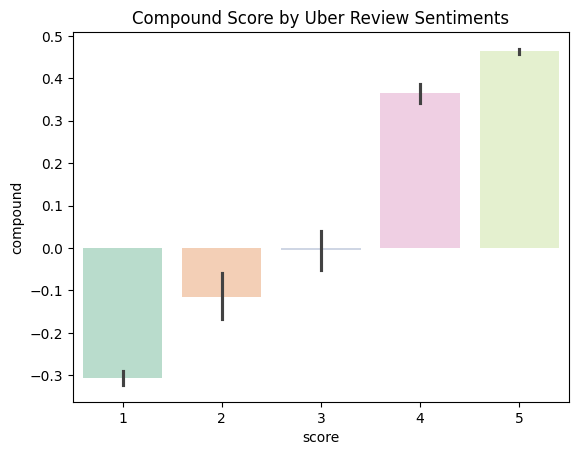

In [34]:
ax = sns.barplot(data=uber, x='score', y='vader_com', palette='Pastel2')

ax.set_title('Compound Score by Uber Review Sentiments')
ax.set_ylabel('compound')

<ipython-input-37-658077e177be>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=uber, x='score', y='vader_pos', palette='Pastel2', ax=axes[0])
<ipython-input-37-658077e177be>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=uber, x='score', y='vader_neg', palette='Pastel2', ax=axes[1])
<ipython-input-37-658077e177be>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=uber, x='score', y='vader_neu', palette='Pastel2', ax=axes[2])


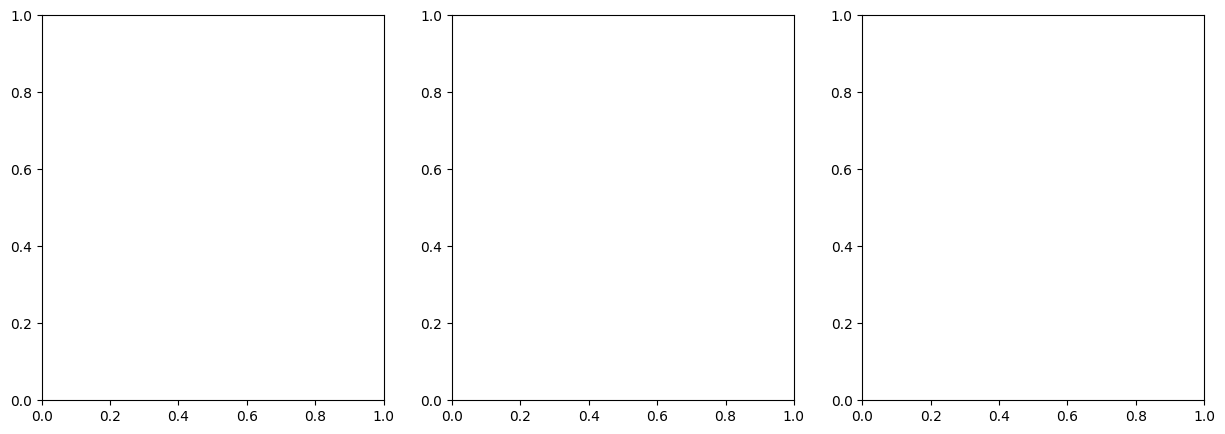

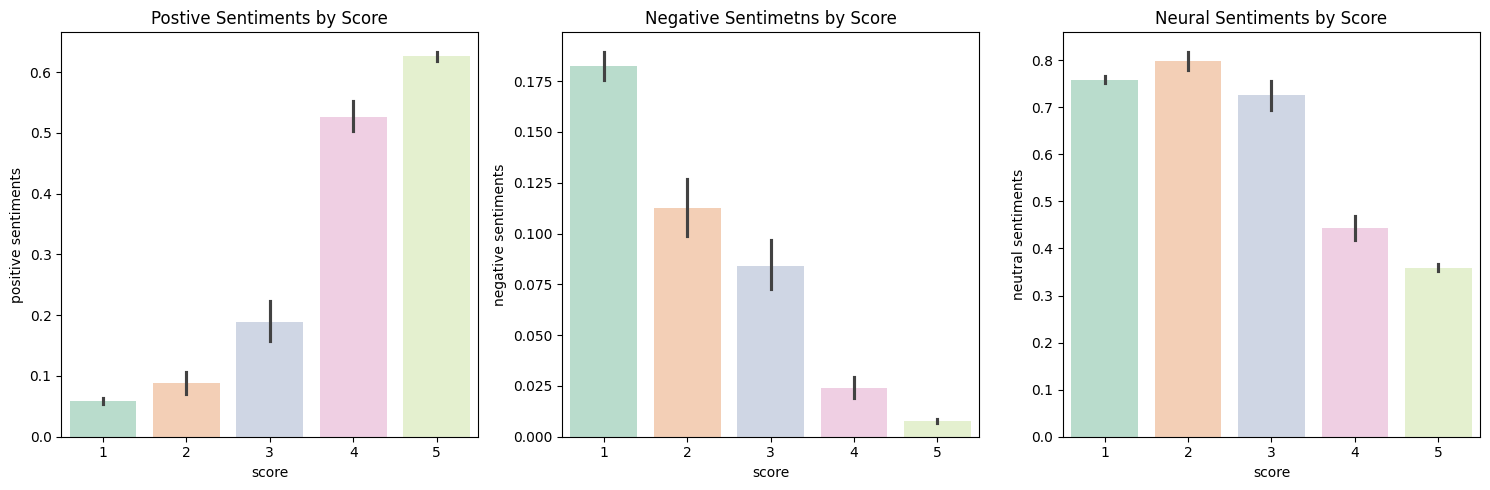

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = sns.barplot(data=uber, x='score', y='vader_pos', palette='Pastel2', ax=axes[0])
ax = sns.barplot(data=uber, x='score', y='vader_neg', palette='Pastel2', ax=axes[1])
ax = sns.barplot(data=uber, x='score', y='vader_neu', palette='Pastel2', ax=axes[2])

axes[0].set_title('Postive Sentiments by Score')
axes[1].set_title('Negative Sentiments by Score')
axes[2].set_title('Neutral Sentiments by Score')

axes[0].set_ylabel('positive sentiments')
axes[1].set_ylabel('negative sentiments')
axes[2].set_ylabel('neutral sentiments')

plt.tight_layout()
axes[1].set_title('Negative Sentimetns by Score')
axes[2].set_title('Neutral Sentiments by Score')

axes[0].set_ylabel('postive sentiments')
axes[1].set_ylabel('negative sentiments')
axes[2].set_title('Neural Sentiments by Score')

axes[0].set_ylabel('positive sentiments')
axes[1].set_ylabel('negative sentiments')
axes[2].set_ylabel('neutral sentiments')

plt.tight_layout()

In [41]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_punctuation_stopwords(review):
    #remove punctuation
    #review = review.translate(str.maketrans('','',string.punctuation))

    #remove stopwords
    words = review.split()
    cleaned_review = [word for word in words if word.lower() not in stop_words]

    return ' '.join(cleaned_review)


#content = uber['content'].apply(remove_punctuation_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<Axes: title={'center': 'Trends in App Performance across Different Versions'}, xlabel='app version', ylabel='average score'>

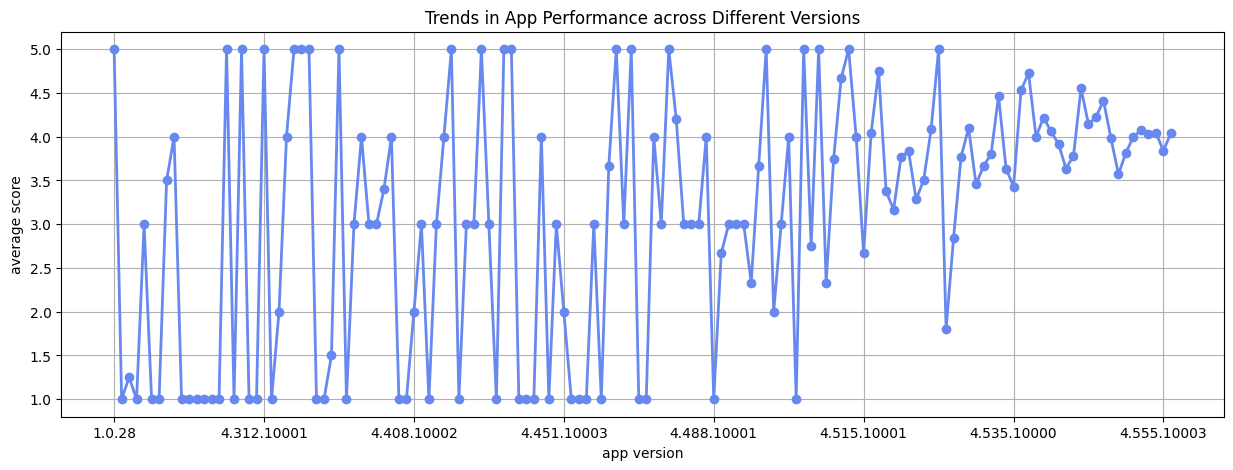

In [43]:
#App Performance across Different Versions
version_score = uber.groupby('reviewCreatedVersion')['score'].mean()

version_score.plot(grid=True, figsize=(15,5), color=sns.color_palette('coolwarm'),
                  marker='o', xlabel='app version', ylabel='average score',
                   linewidth=2,
                   title='Trends in App Performance across Different Versions')